In [34]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [35]:
# Base directory
BASE_DIR = Path("../../data")
RAW_DIR = BASE_DIR / "raw" / "widsdatathon2025"
PROCESSED_DIR = BASE_DIR / "preprocessed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

In [36]:
# Load Training Data
train_cat = pd.read_excel(RAW_DIR / "TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
train_fcm = pd.read_csv(RAW_DIR / "TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv")
train_quant = pd.read_excel(RAW_DIR / "TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx")
train_solutions = pd.read_excel(RAW_DIR / "TRAIN/TRAINING_SOLUTIONS.xlsx")

In [37]:
# Load Test Data
test_cat = pd.read_excel(RAW_DIR / "TEST/TEST_CATEGORICAL.xlsx")
test_fcm = pd.read_csv(RAW_DIR / "TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
test_quant = pd.read_excel(RAW_DIR / "TEST/TEST_QUANTITATIVE_METADATA.xlsx")

In [38]:
# print number of columns
print(f"Number of columns in train_cat {len(train_cat.columns)}")
print(f"Number of columns in test_cat {len(test_cat.columns)}")

print(f"Number of columns in train_fcm {len(train_fcm.columns)}")
print(f"Number of columns in test_fcm {len(test_fcm.columns)}")

print(f"Number of columns in train_quant {len(train_quant.columns)}")
print(f"Number of columns in test_quant {len(test_quant.columns)}")

print(f"Number of columns in train_solutions {len(train_solutions.columns)}")

Number of columns in train_cat 10
Number of columns in test_cat 10
Number of columns in train_fcm 19901
Number of columns in test_fcm 19901
Number of columns in train_quant 19
Number of columns in test_quant 19
Number of columns in train_solutions 3


In [39]:
# See if any columns are different 
columns_train_cat = set(train_cat.columns)
columns_test_cat = set(test_cat.columns)
diff = list(columns_train_cat - columns_test_cat)
diff

[]

In [40]:
def one_hot_encode(df, reference_cols=None):
    """Convert integer categorical columns to category type, then one-hot encode."""
    for col in df.select_dtypes(include='int').columns:
        df[col] = df[col].astype('category')

    columns_to_encode = df.columns[1:].tolist()  # Remove participant_id
    encoded = pd.get_dummies(df[columns_to_encode], drop_first=True)

    encoded = encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x)) # Copied from tutorial

    if reference_cols is not None:
        # Making sure that the test set has same number columns as train set after encoding
        missing_cols = set(reference_cols) - set(encoded.columns)
        for col in missing_cols:
            encoded[col] = 0  # Fill in missing columns with just zeros
        
        encoded = encoded[reference_cols]  # Reorder columns to match train set

    return pd.concat([df.drop(columns=columns_to_encode), encoded], axis=1)

# One-hot encode train set
train_cat_encoded = one_hot_encode(train_cat)

# Get reference columns after encoding
reference_columns = train_cat_encoded.columns[1:].tolist() 

# One-hot encode test set using train's columns
test_cat_encoded = one_hot_encode(test_cat, reference_cols=reference_columns)


/var/folders/qq/2xq_hbb10j75t18jqwpwnfzh0000gn/T/ipykernel_4524/2307149497.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  encoded = encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x)) # Copied from tutorial
/var/folders/qq/2xq_hbb10j75t18jqwpwnfzh0000gn/T/ipykernel_4524/2307149497.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  encoded = encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x)) # Copied from tutorial


In [41]:
# Number of columns after one hot encoding
print(f"number of columns in train_cat_encoded {len(train_cat_encoded.columns)}")
print(f"number of columns in test_cat_encoded {len(test_cat_encoded.columns)}")

number of columns in train_cat_encoded 55
number of columns in test_cat_encoded 55


In [42]:
# Merge DataFrames for Train & Test
# Using outer join to keep all participant IDs (fills in missing values with NaN)
train_cat_fcm = pd.merge(train_cat_encoded, train_fcm, on='participant_id', how='outer')
train_df = pd.merge(train_cat_fcm, train_quant, on='participant_id', how='outer')

test_cat_fcm = pd.merge(test_cat_encoded, test_fcm, on='participant_id', how='outer')
test_df = pd.merge(test_cat_fcm, test_quant, on='participant_id', how='outer')

In [43]:
# Get number of columns
print(f"Number of columns in train_df: {len(train_df.columns)}")
print(f"Number of columns in test_df: {len(test_df.columns)}")

Number of columns in train_df: 19973
Number of columns in test_df: 19973


In [44]:
# Handle Missing Values
def fill_missing_values(df):
    """Fill missing values with column means for numerical columns."""
    for col in df.columns:
        if df[col].isna().sum() > 0 and df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(df[col].mean())
    return df

train_df = fill_missing_values(train_df)
test_df = fill_missing_values(test_df)

In [45]:
# Train and Test Split
X_train = train_df.drop(columns=['participant_id'])
y_train = train_solutions.drop(columns=['participant_id'])

X_test = test_df.drop(columns=['participant_id'])

In [46]:
# Normalize Data using Standard Scaler
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test) 

# Convert back to dataframe
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

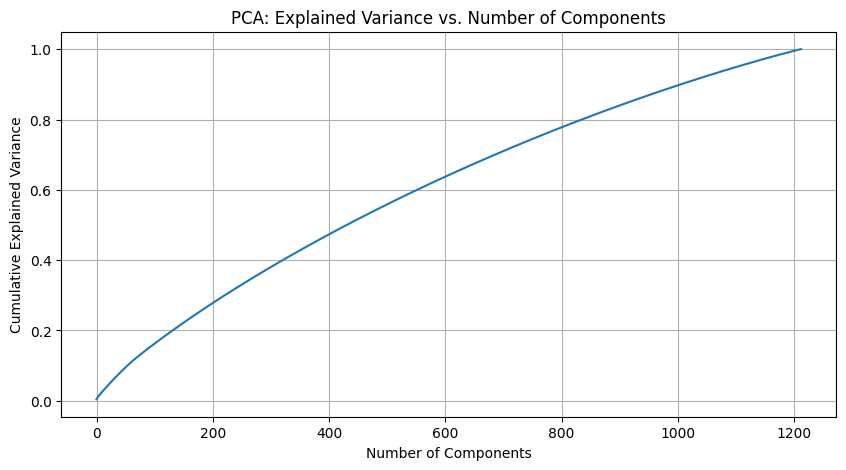

Number of components needed to explain 90% variance: 1007


In [47]:
# Determine optimal components to explain 90% variance
pca_full = PCA().fit(X_train_normalized)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Number of Components')
plt.grid()
plt.show()

print(f"Number of components needed to explain 90% variance: {n_components_90}")

In [48]:
# PCA
pca = PCA(n_components=n_components_90) # Using best number of components
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized) 

# Convert PCA results to DataFrame
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(n_components_90)])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(n_components_90)])

In [49]:
# Add back participant_id
X_train_normalized.insert(0, 'participant_id', train_df['participant_id'].values)
X_test_normalized.insert(0, 'participant_id', test_df['participant_id'].values)

X_train_pca.insert(0, 'participant_id', train_df['participant_id'].values)
X_test_pca.insert(0, 'participant_id', test_df['participant_id'].values)

In [50]:
# Save Processed Data
train_df.to_csv(PROCESSED_DIR / "train_data.csv", index=False)
test_df.to_csv(PROCESSED_DIR / "test_data.csv", index=False)

X_train_normalized.to_csv(PROCESSED_DIR / "train_data_scaled.csv", index=False)
X_test_normalized.to_csv(PROCESSED_DIR / "test_data_scaled.csv", index=False) 

X_train_pca.to_csv(PROCESSED_DIR / "train_data_pca.csv", index=False)
X_test_pca.to_csv(PROCESSED_DIR / "test_data_pca.csv", index=False)  